In [42]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [43]:
def parse_data_from_csv(file_path, reshape=(None, None)):
    with open(file_path) as file:
        labels = []
        data = []

        csv_reader = csv.reader(file, delimiter='\n')
        print(next(csv_reader))
        for row in csv_reader:
            try:
                row = row[0].split(',')
                data.append(float(row[-1]))
                labels.append(len(data))
                # break
            except:
                print(f' exception during: {row}')

        labels = np.array(labels, dtype=np.float32)
        data = np.array(data)

        return data, labels

In [44]:
def tf_windowed_dataset(data, window_size, batch_size, shuffle_buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [45]:
file_path = './daily-minimum-temperatures-in-me.csv'
data, labels = parse_data_from_csv(file_path)

['Date,Daily minimum temperatures']
 exception during: ['7/20/1982', '?0.2']
 exception during: ['7/21/1982', '?0.8']
 exception during: ['7/14/1984', '?0.1']


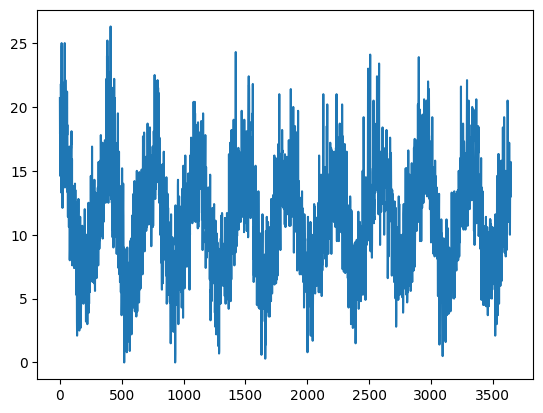

In [46]:
plt.plot(range(3647), data)
plt.show()

In [47]:
window_size = 10
batch_size = 5
shuffle_buffer = 100
split_size = 2300

train_y = data[:split_size]

valid_  y = data[split_size:]

print(f'train length: {len(train_y)}')
print(f'validation length: {len(valid_y)}')

train length: 2300
validation length: 1347


In [48]:
train_dataset = tf_windowed_dataset(train_y, window_size, batch_size, shuffle_buffer)
val_dataset = tf_windowed_dataset(valid_y, window_size, batch_size, shuffle_buffer)

In [49]:
model = tf.keras.Sequential([
    # tf.keras.layers.Conv1D(32, 3, dilation_rate=3 ,padding='same', activation='relu',input_shape=[None, 1]),
    # tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True),input_shape=[None, 1]), # copy/remove the input shape here if you don't want to use Conv1D
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

loss = tf.keras.losses.Huber()
optim = tf.keras.optimizers.Adam(4*1e-4)
cb = tf.keras.metrics.MeanAbsoluteError(name='MAE')

model.compile(
    loss = loss,
    optimizer=optim,
    metrics=[cb]
)


In [50]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data= val_dataset
)


Epoch 1/100
459/459 [==============================] - 6s 8ms/step - loss: 4.0513 - MAE: 4.5246 - val_loss: 2.4151 - val_MAE: 2.8827
Epoch 2/100
459/459 [==============================] - 3s 6ms/step - loss: 1.7853 - MAE: 2.2340 - val_loss: 1.6119 - val_MAE: 2.0583
Epoch 3/100
459/459 [==============================] - 3s 6ms/step - loss: 1.5989 - MAE: 2.0419 - val_loss: 1.4866 - val_MAE: 1.9254
Epoch 4/100
459/459 [==============================] - 3s 6ms/step - loss: 1.5612 - MAE: 2.0041 - val_loss: 1.4583 - val_MAE: 1.8986
Epoch 5/100
459/459 [==============================] - 3s 7ms/step - loss: 1.5296 - MAE: 1.9740 - val_loss: 1.4708 - val_MAE: 1.9131
Epoch 6/100
459/459 [==============================] - 3s 7ms/step - loss: 1.5277 - MAE: 1.9689 - val_loss: 1.4810 - val_MAE: 1.9223
Epoch 7/100
459/459 [==============================] - 3s 7ms/step - loss: 1.5193 - MAE: 1.9607 - val_loss: 1.4169 - val_MAE: 1.8565
Epoch 8/100
459/459 [==============================] - 3s 7ms/step - 

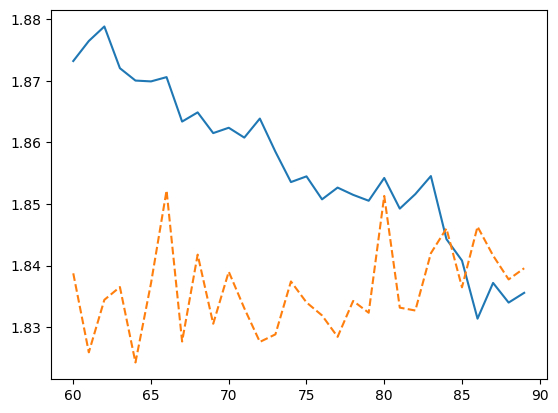

In [60]:
plt.plot(range(60,90), history.history['MAE'][60:90])
plt.plot(range(60,90), history.history['val_MAE'][60:90],'--')
plt.show()